In [1]:
import numpy as np
from DP.utils import fisher_gradient, fisher_information_privatized, is_epsilon_private
import cvxpy as cp

def project_onto_feasible_set(Q, epsilon):
    n_plus_1 = Q.shape[0]
    Q_var = cp.Variable((n_plus_1, n_plus_1))
    Q_param = Q

    # Objective: minimize ||Q_var - Q_param||_F^2
    objective = cp.Minimize(cp.sum_squares(Q_var - Q_param))

    # Constraints
    constraints = []

    # Non-negativity
    constraints += [Q_var >= 0]

    # Column sums
    for j in range(n_plus_1):
        constraints += [cp.sum(Q_var[:, j]) == 1]

    # ε-Differential Privacy constraints
    exp_eps = np.exp(epsilon)
    exp_neg_eps = np.exp(-epsilon)
    for i in range(n_plus_1):
        for j in range(n_plus_1):
            for j_prime in range(n_plus_1):
                if j != j_prime:
                    constraints += [Q_var[i, j_prime] - exp_neg_eps * Q_var[i, j] >= 0]
                    constraints += [exp_eps * Q_var[i, j_prime] - Q_var[i, j] >= 0]

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    return Q_var.value


def linesearch(p_theta, p_theta_dot, epsilon, q, n, theta):
    max_iters = 100
    alpha_init = 0.1
    beta = 0.8
    c = 1e-4
    history = [q]

    for t in range(max_iters):
        I_current = fisher_information_privatized(q, n, theta)
        grad_I = fisher_gradient(p_theta, p_theta_dot, q)

        alpha = alpha_init
        while True:
            q_new = q + alpha * grad_I
            q_new = project_onto_feasible_set(q_new, epsilon)

            I_new = fisher_information_privatized(q_new, n, theta)

            if I_new >= I_current + c * alpha * np.sum(grad_I + (q_new - q)):
                break
            else:
                alpha *= beta

            if alpha < 1e-8:
                print("Line search failed to find a suitable step size.")

        if np.allclose(q, q_new):
            status = f"Converged after {t+1} iterations."
            break

        if abs(I_current - I_new) < 1e-8:
            status = f"Converged after {t+1} iteratons."
            break

        q = q_new
        history.append(q)
        status = "Max iterations reached without convergence"
    
    return {"Q_matrix": q, "status": status, "history": history}

In [2]:
from scipy.stats import binom
from DP.utils import binom_derivative

n = 3
theta = 0.5
epsilon = 1.0

p_theta = binom.pmf([0, 1, 2, 3], 3, theta)
p_theta_dot = [binom_derivative(i, n, theta) for i in range(4)]

Q_init = np.ones((n + 1, n + 1)) / (n + 1) + np.random.normal(size=(n+1, n+1), scale=0.01)
print(is_epsilon_private(Q_init, epsilon))

Q_init = project_onto_feasible_set(Q_init, epsilon)

result = linesearch(p_theta, p_theta_dot, epsilon, Q_init, n, theta)

print(result["Q_matrix"])
print(result["status"])
print(result["history"])

True
[[0.1740217  0.1740217  0.47303763 0.47303762]
 [0.09492255 0.09492255 0.25802379 0.2580238 ]
 [0.24081083 0.24081084 0.08858846 0.08858846]
 [0.4902449  0.49024489 0.1803501  0.1803501 ]]
Converged after 9 iteratons.
[array([[0.24651067, 0.23649576, 0.23360944, 0.2428565 ],
       [0.23346697, 0.25732513, 0.24943752, 0.26397046],
       [0.2571807 , 0.24345747, 0.24992517, 0.24720807],
       [0.26284168, 0.26272166, 0.2670279 , 0.245965  ]]), array([[0.24961466, 0.22646456, 0.23520035, 0.24826497],
       [0.23656029, 0.24718086, 0.25102562, 0.26934663],
       [0.25407672, 0.25348868, 0.24833426, 0.24179959],
       [0.25974837, 0.27286593, 0.2654398 , 0.24058883]]), array([[0.24609107, 0.21013578, 0.24307341, 0.25964775],
       [0.23302286, 0.23055032, 0.25883041, 0.28058724],
       [0.2576003 , 0.26981746, 0.2404612 , 0.23041682],
       [0.2632858 , 0.28949647, 0.25763501, 0.22934822]]), array([[0.22393811, 0.17635062, 0.26863165, 0.28782549],
       [0.21031076, 0.1954469

In [3]:
is_epsilon_private(result["Q_matrix"], epsilon)

Row 2, cols 0 and 2 aren't private:
exp(epsilon)Q[j_prime]=0.032589873120227
Q[j]=0.24081082804502535


False

In [4]:
for m in result["history"]:
    print(fisher_information_privatized(m, n, theta))

0.0016088235076568776
0.005335591594246939
0.03453205507191369
0.26428551760755103
1.6997038769706814
1.921970317462003
1.9219706709808686
1.9219706106015026
1.9219705504131182


In [5]:
n = 1
theta = 0.5
epsilon = 1.0

p_theta = binom.pmf([0, 1], 1, theta)
p_theta_dot = [binom_derivative(i, n, theta) for i in range(2)]

Q_init = np.ones((n + 1, n + 1)) / (n + 1) + np.random.normal(size=(n+1, n+1), scale=0.01)

Q_init = project_onto_feasible_set(Q_init, epsilon)
Q_init

array([[0.50151677, 0.49956196],
       [0.49848325, 0.50043806]])

In [6]:
is_epsilon_private(Q_init, epsilon)

True

In [7]:
I_current = fisher_information_privatized(Q_init, n, theta)
I_current

np.float64(1.528519876248681e-05)

In [8]:
grad_I = fisher_gradient(p_theta, p_theta_dot, Q_init)
grad_I[-1, :] = 0
grad_I

array([[ 0.0078032 , -0.00783536],
       [ 0.        ,  0.        ]])

In [9]:
alphas = np.linspace(0, 5, 100)
fisher_infs = list()
private = list()

for alpha in alphas:
    q_new = Q_init + alpha * grad_I

    I_new = fisher_information_privatized(q_new, n, theta)
    fisher_infs.append(I_new)
    private.append(is_epsilon_private(q_new, epsilon))

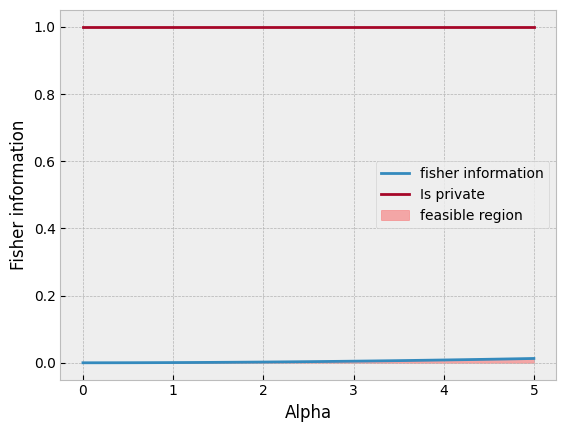

In [10]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("bmh")

plt.plot(alphas, fisher_infs, label="fisher information")
plt.plot(alphas, [int(el) for el in private], label="Is private")
plt.fill_between(alphas, fisher_infs, where=private, color="red", alpha=0.3, label="feasible region")
plt.xlabel("Alpha")
plt.ylabel("Fisher information")
plt.legend()
plt.show()

In [11]:
max_alpha = alphas[private][-1]

q_new = Q_init + max_alpha * grad_I

In [12]:
q_new = project_onto_feasible_set(q_new, epsilon)
q_new

array([[0.52102478, 0.47997357],
       [0.47897525, 0.52002646]])

In [13]:
n = 1
theta = 0.5
epsilon = 1.0

p_theta = binom.pmf([0, 1], 1, theta)
p_theta_dot = [binom_derivative(i, n, theta) for i in range(2)]
p_theta

array([0.5, 0.5])

In [14]:
n_vals = 50

a_vals = np.linspace(0, 1, n_vals)
b_vals = np.linspace(0, 1, n_vals)

grads_a = list()
grads_b = list()
private = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, n, theta))
        private.append(is_epsilon_private(q_mat, epsilon))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

Row 0, cols 0 and 1 aren't private:
exp(-epsilon)Q[j_prime]=0.0075077436973763735
Q[j]=0.0
Row 0, cols 0 and 1 aren't private:
exp(-epsilon)Q[j_prime]=0.015015487394752747
Q[j]=0.0
Row 0, cols 0 and 1 aren't private:
exp(-epsilon)Q[j_prime]=0.02252323109212912
Q[j]=0.0
Row 0, cols 0 and 1 aren't private:
exp(-epsilon)Q[j_prime]=0.030030974789505494
Q[j]=0.0
Row 0, cols 0 and 1 aren't private:
exp(-epsilon)Q[j_prime]=0.03753871848688187
Q[j]=0.0
Row 0, cols 0 and 1 aren't private:
exp(-epsilon)Q[j_prime]=0.04504646218425824
Q[j]=0.0
Row 0, cols 0 and 1 aren't private:
exp(-epsilon)Q[j_prime]=0.05255420588163462
Q[j]=0.0
Row 0, cols 0 and 1 aren't private:
exp(-epsilon)Q[j_prime]=0.06006194957901099
Q[j]=0.0
Row 0, cols 0 and 1 aren't private:
exp(-epsilon)Q[j_prime]=0.06756969327638736
Q[j]=0.0
Row 0, cols 0 and 1 aren't private:
exp(-epsilon)Q[j_prime]=0.07507743697376373
Q[j]=0.0
Row 0, cols 0 and 1 aren't private:
exp(-epsilon)Q[j_prime]=0.08258518067114011
Q[j]=0.0
Row 0, cols 0 and

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:102: RuntimeWarning: invalid value encountered in divide
  gradient_matrix = 2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta - np.outer(
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:171: RuntimeWarning: invalid value encountered in divide
  return np.sum(numerator / denominator)


In [15]:
from DP.linear_solver import linear_solver
from DP.utils import binom_optimal_privacy

opt_solutions, _, _ = binom_optimal_privacy(linear_solver(), n, epsilon, theta)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

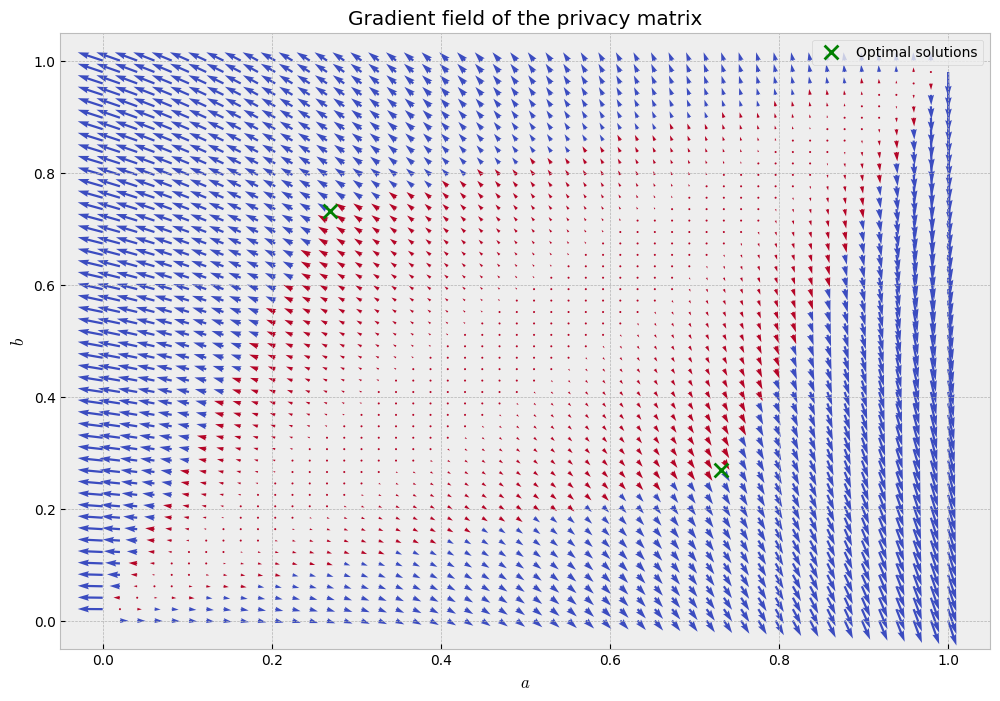

In [16]:
grads_a = np.array(grads_a).reshape((n_vals, n_vals), order="F")
grads_b = np.array(grads_b).reshape((n_vals, n_vals), order="F")
private = np.array(private).reshape((n_vals, n_vals), order="F")
fishers = np.array(fishers).reshape((n_vals, n_vals), order="F")

fig, ax = plt.subplots(figsize=(12, 8))
plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.title("Gradient field of the privacy matrix")
plt.show()

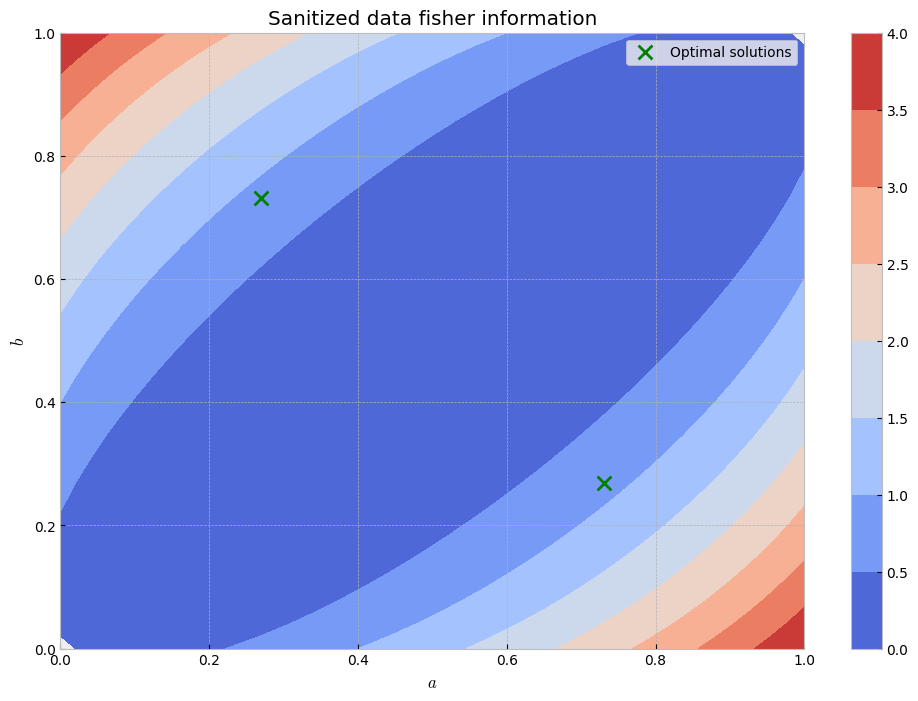

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm")
plt.colorbar()
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.title("Sanitized data fisher information")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.show()

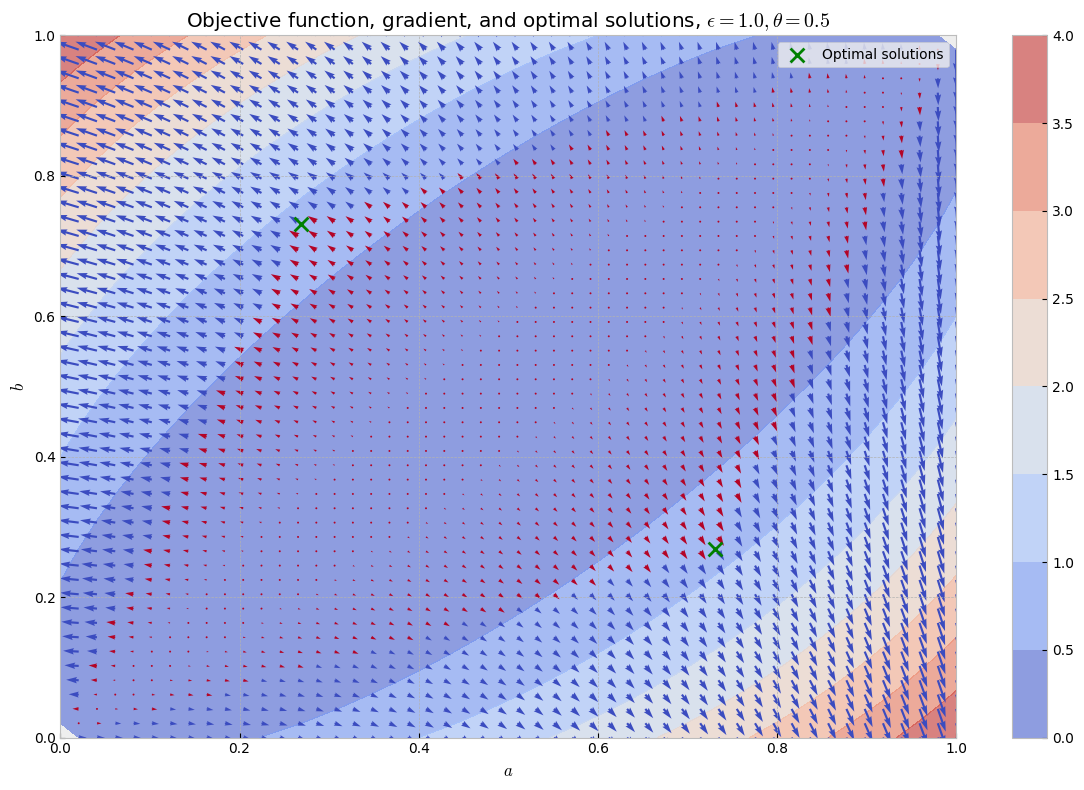

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.6)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.title(r"Objective function, gradient, and optimal solutions, $\epsilon = 1.0, \theta = 0.5$")
plt.tight_layout()
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/var/folders/lv/9hw1_pzj1hs5c2glqrzn04m80000gq/T/ipykernel_30067/337863462.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Feasible region ($\epsilon$ private region)")


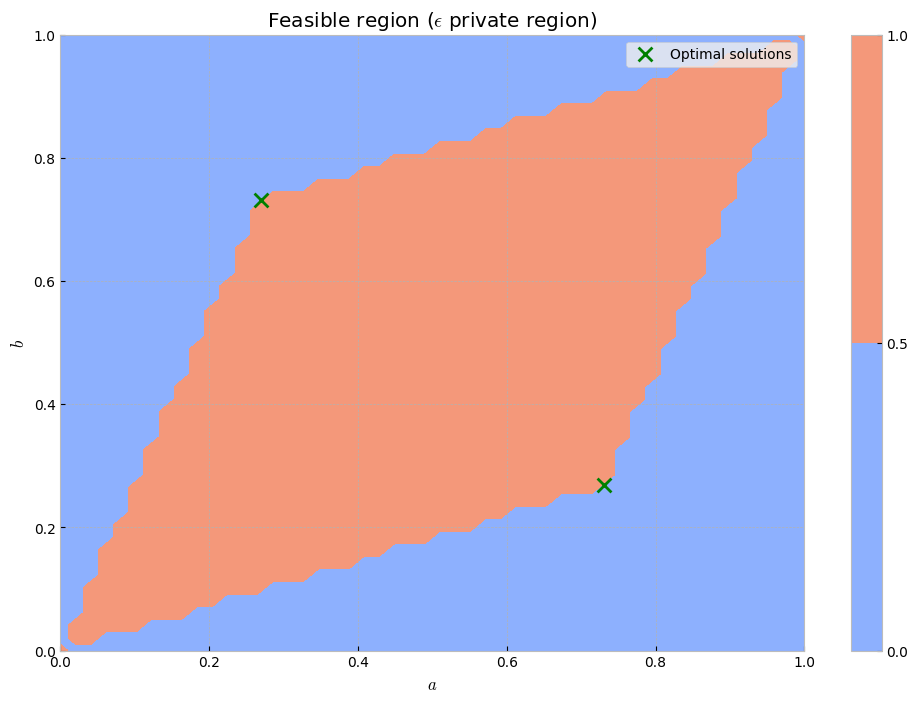

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, private, cmap="coolwarm")
plt.colorbar()
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.title("Feasible region ($\epsilon$ private region)")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.show()

In [20]:
def projected_gradient_ascent(Q_init, p_theta, p_theta_dot, n, theta, epsilon):
    history = [Q_init]
    ascended_history = list()
    fishes = [fisher_information_privatized(Q_init, n, theta)]
    q = Q_init

    for i in range(10):
        grad_I = fisher_gradient(p_theta, p_theta_dot, q)
        grad_I[-1, :] = 0
        q = q + grad_I
        ascended_history.append(q)
        q = project_onto_feasible_set(q, epsilon)
        history.append(q)
        fishes.append(fisher_information_privatized(q, n, theta))

    return history, ascended_history, fishes

Q_init = np.ones((n + 1, n + 1)) / (n + 1) + np.random.normal(size=(n+1, n+1), scale=0.1)
Q_init = project_onto_feasible_set(Q_init, epsilon)
history, ascended_history, fishes = projected_gradient_ascent(Q_init, p_theta, p_theta_dot, n, theta, epsilon)

In [21]:
history = np.array(history)

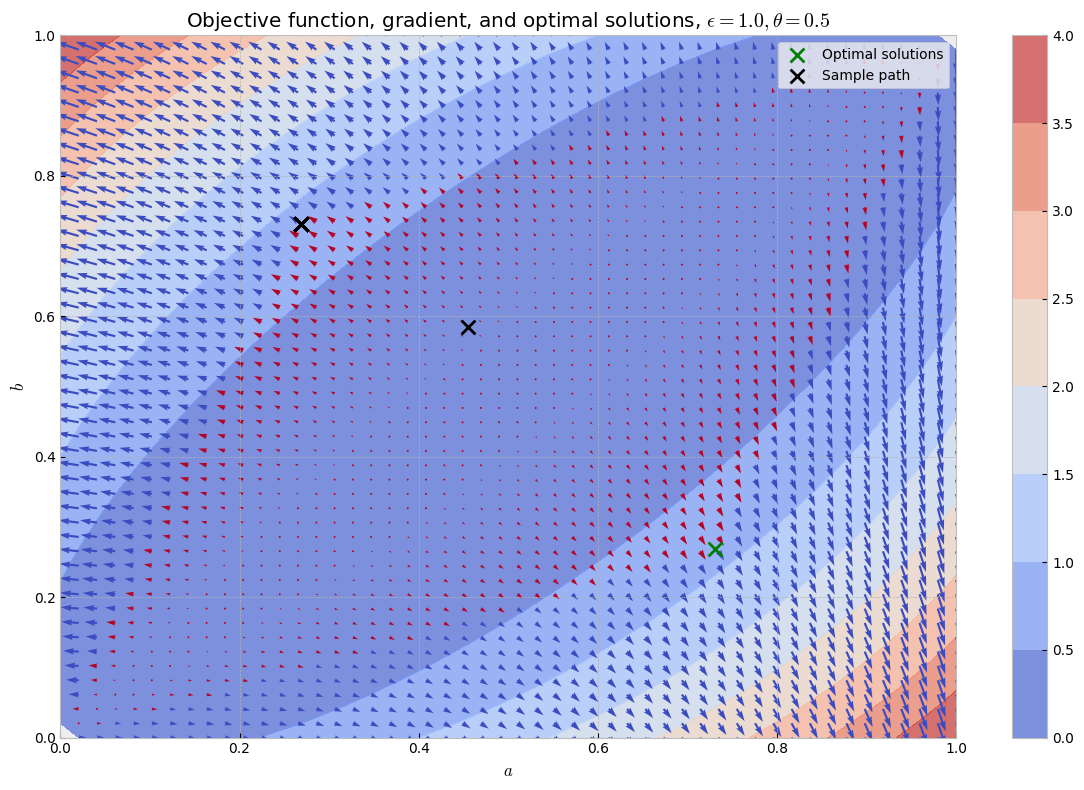

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.scatter(history[:,0,0], history[:,0,1], color="black", marker="x", s=100, label="Sample path")
plt.legend()
plt.title(fr"Objective function, gradient, and optimal solutions, $\epsilon = {epsilon}, \theta = {theta}$")
plt.tight_layout()
plt.show()

In [28]:
def fisher_gradient(
    p_theta: np.ndarray, p_theta_dot: np.ndarray, Q: np.ndarray
) -> np.ndarray:
    """
    Calculates the fisher information gradient at Q,
    given p_theta a vector of probabilities for a specific theta,
    and p_theta_dot a vector of derivatives wrt theta.

    Parameters
    ----------
    p_theta : np.ndarray
        vector of n probabilities for a specific theta
    p_theta_dot : np.ndarray
        vector of n derivatives of probability wrt theta
    Q : np.ndarray
        privacy matrix

    Returns
    -------
    np.ndarray
        gradient matrix pointing in the direction of greatest increase
    """

    # Compute Q @ p_theta and Q @ p_theta_dot for all rows
    Q_ptheta = Q @ p_theta  # Shape: (nrows,)
    Q_ptheta_dot = Q @ p_theta_dot  # Shape: (nrows,)

    # Precompute terms to avoid redundant calculations
    Q_ptheta_squared = np.power(Q_ptheta, 2)  # Element-wise squared values
    Q_ptheta_dot_squared = np.power(Q_ptheta_dot, 2)

    # Compute the numerator and denominator for all elements
    gradient_matrix = 2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta - np.outer(
        p_theta, Q_ptheta_dot_squared
    ) / Q_ptheta_squared

    return gradient_matrix

def fisher_gradient2(
    p_theta: np.ndarray, p_theta_dot: np.ndarray, Q: np.ndarray
) -> np.ndarray:
    """
    Calculates the fisher information gradient at Q,
    given p_theta a vector of probabilities for a specific theta,
    and p_theta_dot a vector of derivatives wrt theta.

    Parameters
    ----------
    p_theta : np.ndarray
        vector of n probabilities for a specific theta
    p_theta_dot : np.ndarray
        vector of n derivatives of probability wrt theta
    Q : np.ndarray
        privacy matrix

    Returns
    -------
    np.ndarray
        gradient matrix pointing in the direction of greatest increase
    """

    nrows, ncols = Q.shape
    gradient_matrix = np.zeros(Q.shape)

    for i in range(nrows):
        Q_row = Q[i]

        for j in range(ncols):
            Q_ptheta_dot = Q_row @ p_theta_dot
            Q_ptheta = Q_row @ p_theta

            gradient_matrix[i][j] = 2 * p_theta_dot[
                j
            ] * Q_ptheta_dot / Q_ptheta - p_theta[j] * np.power(
                Q_ptheta_dot, 2
            ) / np.power(
                Q_ptheta, 2
            )

    return gradient_matrix


In [41]:
q, _, _ = binom_optimal_privacy(linear_solver(), 2, 1.0, 0.5)
q

array([[0.26894142, 0.26894142, 0.73105858],
       [0.73105858, 0.73105858, 0.26894142]])

In [48]:
p_theta = binom.pmf([0, 1, 2], 1, 0.5)
p_theta_dot = np.array([binom_derivative(i, 2, 0.5) for i in range(3)])

In [49]:
%%timeit
fisher_gradient(p_theta, p_theta_dot, q)

6.53 μs ± 101 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [50]:
%%timeit
fisher_gradient2(p_theta, p_theta_dot, q)

14.5 μs ± 380 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [54]:
fisher_gradient(p_theta, p_theta_dot, q)

array([[-4.91280988,  1.06445292],
       [-1.47624622, -0.1997882 ],
       [ 3.43656366, -1.26424112]])

In [52]:
fisher_gradient2(p_theta, p_theta_dot, q)

array([[-4.91280988, -1.47624622,  3.43656366],
       [ 1.06445292, -0.1997882 , -1.26424112]])